# Toy Sales Analysis

## 1. Project Overview
The Toy Sales project analyzes sales and inventory data for Maven Toys, a fictitious chain of toy stores in Mexico. The analysis is designed to uncover key profitability drivers, identify seasonal trends, evaluate stockout impacts, and optimize inventory management to improve operational efficiency and maximize profits. The dataset includes detailed information about products, store locations, daily transactions, and inventory levels.

### 1.1 Key Objectives
- **Profitability Analysis:**\
Identify the product categories that generate the highest profits and assess if the same trends are observed across different store locations.
- **Seasonal Trends:**\
Uncover seasonal and monthly patterns in sales to inform marketing and stocking decisions.
- **Stockout Impact:**\
Determine if sales are being lost due to products being out of stock at specific stores.
- **Inventory Evaluation:**\
Assess inventory value at each store and estimate how long the stock will last based on sales trends.

### 1.2 Methodology
1. **Data Cleaning:**
    - Verified the completeness and consistency of datasets, including sales, inventory, product details, and calendar data.
    - Standardized column formats, such as date fields, and resolved missing or inconsistent values to ensure accuracy in analysis.


2. **SQL Query Execution in Jupyter Notebook:**
    - Connected to the SQL Server database using the pyodbc library for efficient querying and data extraction within Jupyter Notebook.
    - Employed advanced SQL techniques such as grouping, aggregations, ranking, and conditional logic to calculate profitability, identify seasonal trends, and evaluate stockouts.
    - Used Common Table Expressions (CTEs) for complex queries like calculating inventory longevity based on average daily sales.


3. **Visualization in Jupyter Notebook:**
    - Generated visualizations using Matplotlib and Seaborn to present key findings clearly.
    - Created bar charts to illustrate monthly sales trends, pie charts for inventory distribution, and line charts for seasonal sales patterns.
    - Enhanced visual storytelling with color-coded insights, making trends and patterns easily interpretable.

### 1.3 Outcomes

The analysis uncovered key insights into the profitability drivers, seasonal sales patterns, and inventory management for Maven Toys. It highlighted the most profitable product categories across different locations, enabling targeted stocking and marketing strategies. Seasonal trends were identified, offering a clear understanding of peak and off-peak periods to optimize sales campaigns.

Additionally, the assessment of stockouts revealed opportunities to prevent lost sales through better inventory planning and proactive restocking of high-demand products. The evaluation of inventory value and longevity provided an understanding of how much capital is tied up in stock and how long it would last, helping to optimize resource allocation and improve stock turnover.

This project demonstrates the power of data analysis in enhancing operational efficiency and profitability for a retail business while ensuring a better alignment of inventory with customer demand.

In [1]:
# Import libraries

import pyodbc
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
connection_string = ("Driver={ODBC Driver 17 for SQL Server};"
                     "Server=DESKTOP-2RUFIKM\SQLEXPRESS01;"
                     "Database=MexicoToySales;"
                     "Trusted_Connection=yes;")

In [3]:
conn = pyodbc.connect(connection_string)

In [4]:
# Initialize cursor
cursor = conn.cursor()

In [5]:
# Select database

cursor.execute("USE MexicoToySales")

## 2. Preview Tables

### 2.1 Inventory table

In [6]:
query = """
    SELECT
       *
    FROM
    Inventory;
"""

df_inventory = pd.read_sql(query, conn)
df_inventory.head(3)

,Store_ID,Product_ID,Stock_On_Hand
0,1,1,27
1,1,2,0
2,1,3,32


In [7]:
df_inventory.shape

(1593, 3)

### 2.2 Products table

In [8]:
query = """
    SELECT
        *
    FROM
        Products;
"""

df_Products = pd.read_sql(query, conn)
df_Products.head(3)

,Product_ID,Product_Name,Product_Category,Product_Cost,Product_Price
0,1,Action Figure,Toys,9.99,15.99
1,2,Animal Figures,Toys,9.99,12.99
2,3,Barrel O' Slime,Art & Crafts,1.99,3.99


In [9]:
df_Products.shape

(35, 5)

### 2.3 Sales table

In [10]:
query = """
    SELECT
        *
    FROM
        Sales;
"""

df_Sales = pd.read_sql(query, conn)
df_Sales.head(3)

,Sale_ID,Date,Store_ID,Product_ID,Units
0,1,2022-01-01,24,4,1
1,2,2022-01-01,28,1,1
2,3,2022-01-01,6,8,1


In [11]:
df_Sales.shape

(829262, 5)

### 2.4 Stores table

In [12]:
query = """
    SELECT
        *
    FROM
        Stores;
"""

df_Stores = pd.read_sql(query, conn)
df_Stores.head(3)

,Store_ID,Store_Name,Store_City,Store_Location,Store_Open_Date
0,1,Maven Toys Guadalajara 1,Guadalajara,Residential,1992-09-18
1,2,Maven Toys Monterrey 1,Monterrey,Residential,1995-04-27
2,3,Maven Toys Guadalajara 2,Guadalajara,Commercial,1999-12-27


In [13]:
df_Stores.shape

(50, 5)

### 2.5 Create a Calendar table
For queries that involve sales trend (by year and month), it is necessary to use a Calendar table.

In [14]:
# Define the Start and End Dates for the Calendar
query = """
    DECLARE @StartDate DATE = '2022-01-01';
    DECLARE @EndDate DATE = '2023-12-31';

    -- Create Calendar table
    CREATE TABLE Calendar (
        [Date] NVARCHAR(10)
    );
"""

# Populate the Calendar table
query = """
    WITH CTE_Calendar AS (
        SELECT @StartDate AS [Date]
        UNION ALL
        SELECT DATEADD(DAY, 1, [Date])
        FROM CTE_Calendar
        WHERE DATEADD(DAY, 1, [Date]) <= @EndDate
    )
    
    INSERT INTO Calendar ([Date])
    SELECT FORMAT(Date, 'yyyy-MM-dd')
    FROM CTE_Calendar
    OPTION (maxrecursion 0);
"""

In [15]:
# Preview Calendar table

query = """
    SELECT
        Date
    FROM
        Calendar;
"""

df_Calendar = pd.read_sql(query, conn)
df_Calendar

,Date
0,2022-01-01
1,2022-01-02
2,2022-01-03
3,2022-01-04
4,2022-01-05
...,...
725,2023-12-27
726,2023-12-28
727,2023-12-29
728,2023-12-30


## 3. Data Exploration

### 3.1 General Store Information

In [16]:
# 1. General Store Information
# 1a) How many stores in total?
# 1b) How many cities and locations are the stores distributed?

query = """
    SELECT
        COUNT(DISTINCT Store_Name) AS Unique_Stores,
        COUNT(DISTINCT Store_City) AS Unique_Cities,
        COUNT(DISTINCT Store_Location) AS Unique_Locations
    FROM
        Stores;
"""

df_1 = pd.read_sql(query, conn)
df_1

,Unique_Stores,Unique_Cities,Unique_Locations
0,50,29,4


### 3.2 General Product Information

In [18]:
# 2. General Product Information
# a) How many products in total?
# b) How many categories do they belong?
# c) How many products are in each category?

query = """
    SELECT 
        Product_Category, 
        COUNT(*) AS Products_Per_Category 
    FROM 
        Products 
    GROUP BY 
        Product_Category

    UNION ALL

    SELECT 
        'TOTAL' AS Product_Category, 
        COUNT(*) AS Products_Per_Category 
    FROM 
        Products;
"""

df_2 = pd.read_sql(query, conn)
df_2

,Product_Category,Products_Per_Category
0,Art & Crafts,8
1,Electronics,3
2,Games,8
3,Sports & Outdoors,7
4,Toys,9
5,TOTAL,35


There are **35 Products** across **5 Categories** with Toys having the highest of 9 Products, while Electronics has the least, 3.

### 3.3 Inventory Information

In [45]:
# 3. Inventory Information
# 3a) What was the total stock value in each store?

query = """
    SELECT
        --i.Store_ID,
        s.Store_Name,
        SUM(i.Stock_On_Hand * p.Product_Price) AS Total_Stock_Value
    FROM
        Inventory i
    JOIN
        Stores s ON i.Store_ID = s.Store_ID
    JOIN
        Products p ON i.Product_ID = p.Product_ID
    GROUP BY
        --i.Store_ID,
        s.Store_Name
    ORDER BY
        Total_Stock_Value DESC;
"""

df_3a = pd.read_sql(query, conn)
df_3a.head()

,Store_Name,Total_Stock_Value
0,Maven Toys Ciudad de Mexico 2,12067.85
1,Maven Toys Chihuahua 2,11171.26
2,Maven Toys Hermosillo 1,10896.49
3,Maven Toys Hermosillo 3,10777.44
4,Maven Toys Culiacan 1,10349.62


In [21]:
df_3a.shape

(50, 2)

### i) Big Gap in Stock Values
- Some stores have **nearly 3x more stock** than others.
- The highest store holds **over \$12,000**, while the lowest has **less than \$5,000**.
- This could mean **higher demand, better storage, or inefficient stock distribution**.

### ii) Uneven Allocation Across Same-City Stores
- Cities like **Guadalajara, Monterrey, and Ciudad de Mexico** have multiple stores with very different stock levels.
- Some stores in the same city have **almost double the stock** of others.
- This suggests **unequal demand, space limitations, or inconsistent restocking**.

### iii) Northern Cities Dominate Inventory
- **Chihuahua, Hermosillo, and Culiacan** have some of the highest stock values.
- This may indicate **stronger demand, better logistics, or regional supply hubs**.
- Understanding this pattern can help **optimize stock distribution nationwide**.

In [47]:
# 3b) What was the total stock count of each product?

query = """
    SELECT
        --i.Product_ID,
        p.Product_Name,
        SUM(i.Stock_On_Hand) AS Stock_Count
    FROM
        Inventory i
    JOIN
        Products p ON i.Product_ID = p.Product_ID
    GROUP BY
        p.Product_Name
    ORDER BY
        Stock_Count DESC;
"""

df_3b = pd.read_sql(query, conn)
df_3b.head()

,Product_Name,Stock_Count
0,Deck Of Cards,2738
1,Dinosaur Figures,2272
2,PlayDoh Can,2129
3,Magic Sand,1922
4,Rubik's Cube,1497


In [24]:
df_3b.shape

(35, 2)

### Total Stock Value per Store:
- **Deck of Cards leads by a wide margin** — It has the highest stock (2,738), significantly more than other products.

- **Classic and creative play items dominate** — Card games, figures, PlayDoh, and Magic Sand are among the top stocked.

- **Board games have the lowest stock** — Chutes & Ladders, Dominoes, Uno, Monopoly, and Jenga are at the bottom, possibly indicating lower demand or frequent sales.

In [26]:
# 3c) What was the total stock count of each product in each city?

query = """
    SELECT
        s.Store_City,
        --p.Product_ID,
        p.Product_Name,
        SUM(i.Stock_On_Hand) AS Stock_Count
    FROM
        Inventory i
    JOIN
        Stores s ON i.Store_ID = s.Store_ID
    JOIN
        Products p ON i.Product_ID = p.Product_ID
    GROUP BY
        s.Store_City,
        --p.Product_ID,
        p.Product_Name
    ORDER BY
        s.Store_City;
"""

df_3c = pd.read_sql(query, conn)
df_3c

,Store_City,Product_Name,Stock_Count
0,Aguascalientes,Action Figure,11
1,Aguascalientes,Animal Figures,25
2,Aguascalientes,Barrel O' Slime,13
3,Aguascalientes,Chutes & Ladders,1
4,Aguascalientes,Classic Dominoes,4
...,...,...,...
944,Zacatecas,Rubik's Cube,17
945,Zacatecas,Splash Balls,10
946,Zacatecas,Supersoaker Water Gun,9
947,Zacatecas,Teddy Bear,28


### 3.4 Sales and Profit Information

In [28]:
# 4. Sales and Profit Information
# Which product categories drive the highest profits? Is this the same across store locations?
# 4ai) Query to calculate profit by product category:

query = """
    WITH ProfitData AS (
        SELECT 
            p.Product_Category,
            (p.Product_Price - p.Product_Cost) * sa.Units AS Profit
        FROM 
            Sales sa
        JOIN 
            Products p ON sa.Product_ID = p.Product_ID
    )
    SELECT 
        Product_Category,
        SUM(Profit) AS Total_Profit
    FROM 
        ProfitData
    GROUP BY 
        Product_Category
    ORDER BY 
        Total_Profit DESC;
"""

df_4ai = pd.read_sql(query, conn)
df_4ai

,Product_Category,Total_Profit
0,Toys,1079527.0
1,Electronics,1001437.0
2,Art & Crafts,753354.0
3,Games,673993.0
4,Sports & Outdoors,505718.0


In [29]:
# Calculate the total profit
total_profit = df_4ai["Total_Profit"].sum()

# Calculate the top 2 categories' profit
top_2_profit = df_4ai.nlargest(2, "Total_Profit")["Total_Profit"].sum()

# Calculate the percentage contribution
percentage_contribution = (top_2_profit / total_profit) * 100

print(f"{percentage_contribution:.2f}%")


51.84%


### Highest Profit Categories:
- **Toys and Electronics** had the highest profits.
- They contributed about **52%** of the overall profit.

In [31]:
# 4aii) Query to calculate profit by store location and product category:

query = """
    WITH ProfitData AS (
        SELECT 
            s.Store_Location,
            p.Product_Category,
            (p.Product_Price - p.Product_Cost) * sa.Units AS Profit
        FROM 
            Sales sa
        JOIN 
            Stores s ON sa.Store_ID = s.Store_ID
        JOIN 
            Products p ON sa.Product_ID = p.Product_ID
    ),
    CategoryProfits AS (
        SELECT 
            Store_Location,
            Product_Category,
            SUM(Profit) AS Total_Profit,
            RANK() OVER (PARTITION BY Store_Location ORDER BY SUM(Profit) DESC) AS Rank_In_Location
        FROM 
            ProfitData
        GROUP BY 
            Store_Location, Product_Category
    )
    SELECT 
        Store_Location,
        Product_Category,
        Total_Profit,
        Rank_In_Location
    FROM 
        CategoryProfits
    WHERE 
        Rank_In_Location <= 3
    ORDER BY 
        Store_Location, Rank_In_Location;
"""

df_4aii = pd.read_sql(query, conn)
df_4aii

,Store_Location,Product_Category,Total_Profit,Rank_In_Location
0,Airport,Electronics,108197.0,1
1,Airport,Toys,88250.0,2
2,Airport,Games,80768.0,3
3,Commercial,Electronics,287574.0,1
4,Commercial,Toys,225034.0,2
5,Commercial,Art & Crafts,155461.0,3
6,Downtown,Toys,630029.0,1
7,Downtown,Electronics,502490.0,2
8,Downtown,Art & Crafts,444320.0,3
9,Residential,Toys,136214.0,1


### Key Insights:
1. **Toys and Electronics:**\
    Drive the **highest overall profits**, but their dominance vary by location.


2. **Electronics:**\
    Perform best in **high-traffic areas** (Airport, Commercial), suggesting demand for convenience-driven purchases.


3. **Toys:**\
    Dominate in **Downtown and Residential areas**, likely due to family-oriented customer bases.
    

4. **Art & Crafts:**\
    Rank **consistently in the top three** across multiple locations, indicating steady demand across different demographics.

### Recommendation:

Profitability is location-dependent.
A targeted strategy — **expanding Electronics in high-footfall areas and boosting Toys in residential/downtown stores** — could maximize overall revenue.

In [33]:
# 4b) Can you find any seasonal trends or patterns in the sales data?
# Query to analyze yearly and monthly sales trends:

query = """
    SELECT
        YEAR(CAST(c.Date AS DATE)) AS Year,
        MONTH(CAST(c.Date AS DATE)) AS Month_Num,
        DATENAME(MONTH, CAST(c.Date AS DATE)) AS Month_Name,
        SUM(s.Units) as Quantity_Sold,
        SUM(s.Units * p.Product_Price) AS Total_Revenue
    FROM 
        sales s
    JOIN 
        calendar c ON s.Date = c.Date
    JOIN 
        products p ON s.Product_ID = p.Product_ID
    GROUP BY
        YEAR(CAST(c.Date AS DATE)), 
        MONTH(CAST(c.Date AS DATE)), 
        DATENAME(MONTH, CAST(c.Date AS DATE))
    ORDER BY
        Year, Month_Num;
"""

df_4b = pd.read_sql(query, conn)
df_4b

,Year,Month_Num,Month_Name,Quantity_Sold,Total_Revenue
0,2022,1,January,38009,542554.91
1,2022,2,February,36935,541351.65
2,2022,3,March,39981,589485.19
3,2022,4,April,47102,681072.98
4,2022,5,May,46910,672369.90
5,2022,6,June,47178,661980.22
6,2022,7,July,46177,556034.23
7,2022,8,August,39927,489422.73
8,2022,9,September,42196,585844.04
9,2022,10,October,47861,623874.39


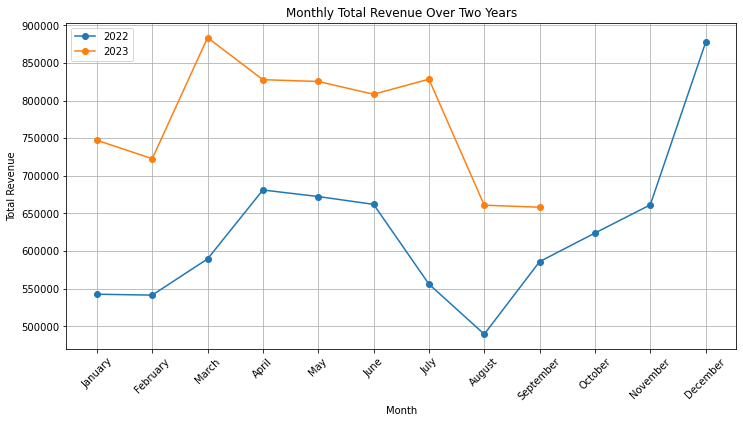

In [50]:
# Plotting
plt.figure(figsize=(12, 6))
for year in df_4b["Year"].unique():
    subset = df_4b[df_4b["Year"] == year]
    plt.plot(subset["Month_Name"], subset["Total_Revenue"], marker='o', label=str(year))

plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.title("Monthly Total Revenue Over Two Years")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Save plot as a PNG image
plt.savefig('monthly total revenue.png', dpi=300, bbox_inches='tight')

plt.show()

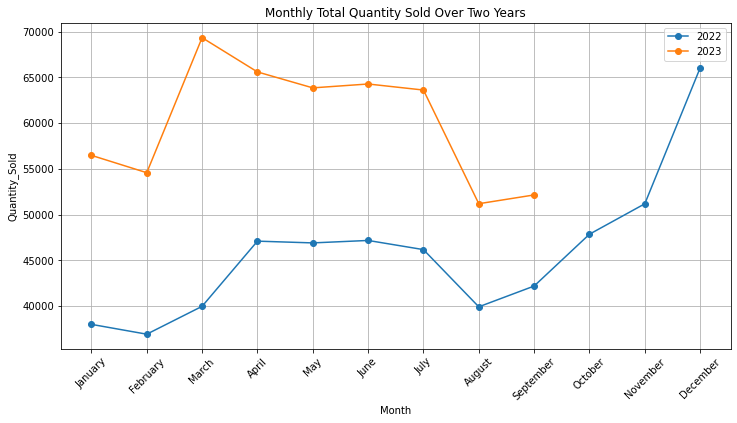

In [49]:
# Plotting
plt.figure(figsize=(12, 6))
for year in df_4b["Year"].unique():
    subset = df_4b[df_4b["Year"] == year]
    plt.plot(subset["Month_Name"], subset["Quantity_Sold"], marker='o', label=str(year))

plt.xlabel("Month")
plt.ylabel("Quantity_Sold")
plt.title("Monthly Total Quantity Sold Over Two Years")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Seasonal Sales Trends:
- **December has the highest sales spike** – Likely due to holiday shopping, with a peak in both quantity sold and revenue.
- **Consistent sales from March to July** – Sales remain high, possibly due to school breaks and summer activities.
- **August sees a noticeable dip** – A potential back-to-school effect, where spending shifts to educational needs.

In [38]:
# 4c) Are sales being lost with out-of-stock products at certain locations?
# Query to find locations with out-of-stock products that had sales orders:

query = """
    SELECT 
        st.Store_Location,
        SUM(s.Units) AS Units_Ordered
        --i.Stock_On_Hand
    FROM
        Sales s
    JOIN
        Products p ON s.Product_ID = p.Product_ID
    JOIN
        Inventory i ON s.Store_ID = i.Store_ID AND s.Product_ID = i.Product_ID
    JOIN
        Stores st ON s.Store_ID = st.Store_ID
    WHERE
        i.Stock_On_Hand = 0
    GROUP BY
        st.Store_Location
    ORDER BY
        Units_Ordered DESC;    
"""

df_4c = pd.read_sql(query, conn)
df_4c

,Store_Location,Units_Ordered
0,Downtown,18310
1,Commercial,5985
2,Residential,5629
3,Airport,888


### Insight:
Stockouts are causing lost sales, especially at **Downtown**. 

### Recommendation:
Improving restocking at high-demand locations like Downtown, Commercial, and Residential could reduce sales losses.

In [40]:
# 4d) How much money is tied up in inventory at the toy stores? How long will it last?
# Query to calculate the inventory value and estimate how long it will last:

query = """
    WITH InventoryValue AS (
        SELECT 
            SUM(i.Stock_On_Hand * p.Product_Cost) AS Total_Inventory_Value
        FROM Inventory i
        JOIN Products p ON i.Product_ID = p.Product_ID
    ),
    TotalDailySales AS (
        SELECT
            SUM(s.Units) / COUNT(DISTINCT s.Date) AS Avg_Daily_Sales
        FROM Sales s
    )
    SELECT 
        iv.Total_Inventory_Value,
        CASE
            WHEN tds.Avg_Daily_Sales > 0 THEN CAST(ROUND(iv.Total_Inventory_Value / tds.Avg_Daily_Sales, 0) AS INT)
            ELSE NULL
        END AS Estimated_Days_Of_Stock
    FROM InventoryValue iv, TotalDailySales tds;
    """

df_4d = pd.read_sql(query, conn)
df_4d.head(3)

,Total_Inventory_Value,Estimated_Days_Of_Stock
0,300209.58,176


### Inventory Status and Stock Sustainability:
- **176 days of stock** indicates extended availability.
- **\$300,209.58** tied up in inventory impacts cash flow.
- **Restocking strategy** should match demand trends.